<a href="https://colab.research.google.com/github/timlovescoding/traffic_symbols/blob/master/Classifying_Traffic_Symbols_for_Self_Driving_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

Using TensorFlow backend.


In [0]:
# Opening the datasets, getting the data:

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [0]:
# Datasets are in the form of a dictionary:

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [7]:
# understanding the datasets that we are working with:

print('Training Data-Input: ' + str(x_train.shape))
print('Training Data-Output: ' + str(y_train.shape))
print('Validation Data-Input: ' + str(x_val.shape))
print('Vaolidation Data-Output: ' + str(y_val.shape))
print('Testing Data-Input: ' + str(x_test.shape))
print('Testing Data-Output: ' + str(y_test.shape))

Training Data-Input: (34799, 32, 32, 3)
Training Data-Output: (34799,)
Validation Data-Input: (4410, 32, 32, 3)
Vaolidation Data-Output: (4410,)
Testing Data-Input: (12630, 32, 32, 3)
Testing Data-Output: (12630,)


In [8]:
# use pandas to deal with CSV file (CSV file contains the labels for each class)

data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data) # understand the CSV file you are working with

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

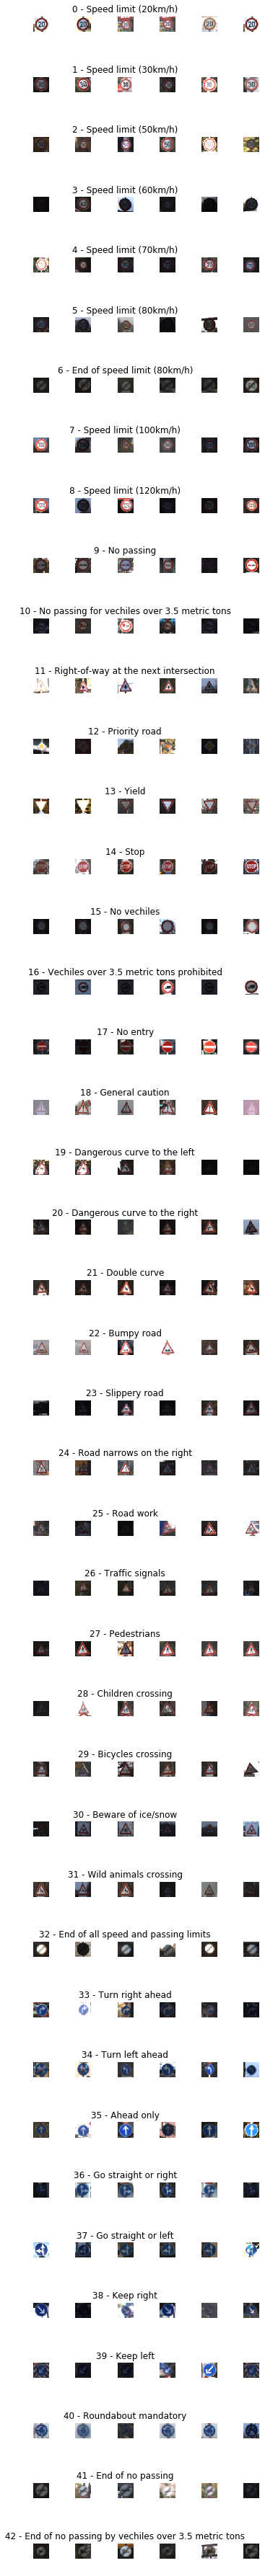

In [9]:
# Plotting some of the data for visualization of the data you are working with:

samples  = []

column = 6
number_of_classes = len(data["ClassId"])  #number of classes

fig, axs = plt.subplots(nrows=number_of_classes, ncols=column, figsize=(5,50))
fig.tight_layout()
 
for i in range(column):
      for index , row in data.iterrows(): #iterating through the dataframe row by row
        x_selected = x_train[y_train == index] #The dataset that is the label
        axs[index][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[index][i].axis("off")
        
        # middle of figure
        if i == 2:
          axs[index][i].set_title(str(index) + " - " + row["SignName"])
          samples.append(len(x_selected))  #take advantage of this (since it gets only called once in the loop), to get a list of the number of samples per class
          


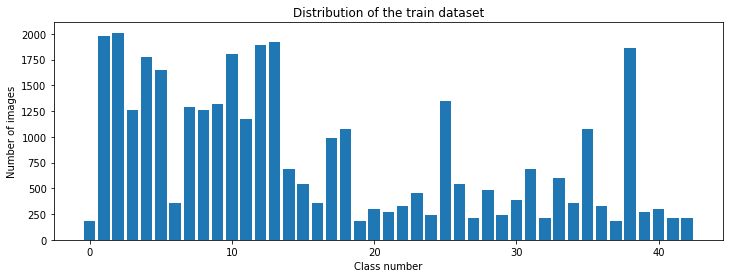

In [10]:
# Visualising the amount of dataset per entry of classes:

plt.figure(figsize=(12, 4))
plt.bar(range(0, number_of_classes), samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [0]:
# Got a hunch that CNN model is training is too skewed as some classes are highly dense. Testing accuracy is somehow high, I want to check the testing datasets whether are the classes density 
# similar to that of the training set
# The guess of the skewness was due to the AI failing to classify certain obvious traffic symbols from the web. You can try some of the URL I used at the last cell


#*** Insert the code cell here before one-hot encoding as it changes the labels.

test_samples = []

for index , _ in data.iterrows():  #iterating through the dataframe row by row
       
      x_test_selected = x_test[y_test == index] #The dataset that is the label
      test_samples.append(len(x_test_selected))  #take advantage of this (since it gets only called once in the loop), to get a list of the number of samples per class

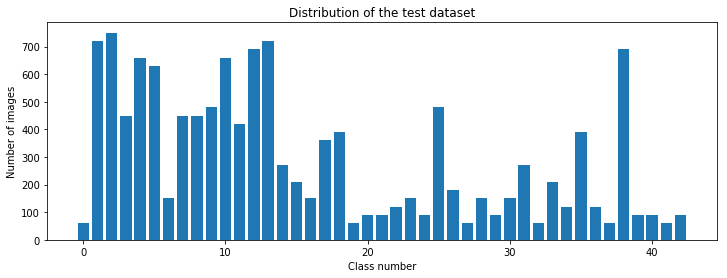

In [12]:
# Plotting the bar graph for testing samples:

plt.figure(figsize=(12, 4))
plt.bar(range(0, number_of_classes), test_samples)
plt.title("Distribution of the test dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [0]:
# My hunch was right, the testing dataset density and the training dataset density is too similar.

# That's why it does very poorly still when you try to classify traffic symbols that are under-represented in the datasets!

In [0]:
# Pre-process images:

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #conversion to gray scale images
    img = cv2.equalizeHist(img)   #histogram equalizer
    img = img/255
    return img
  
  
x_train = np.array(list(map(preprocess, x_train)))
x_test = np.array(list(map(preprocess, x_test)))
x_val = np.array(list(map(preprocess, x_val)))

In [15]:
# Re-read the shapes: Make sure it is 2D without any channels now

print('Training Data-Input: ' + str(x_train.shape))
print('Training Data-Output: ' + str(y_train.shape))
print('Validation Data-Input: ' + str(x_val.shape))
print('Vaolidation Data-Output: ' + str(y_val.shape))
print('Testing Data-Input: ' + str(x_test.shape))
print('Testing Data-Output: ' + str(y_test.shape))

Training Data-Input: (34799, 32, 32)
Training Data-Output: (34799,)
Validation Data-Input: (4410, 32, 32)
Vaolidation Data-Output: (4410,)
Testing Data-Input: (12630, 32, 32)
Testing Data-Output: (12630,)


In [0]:
# note that for CNN, we need it to be 3D, so the 3rd dimension of a gray scale image is just 1

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)

In [17]:
# Re-checking dimension to ensure it is of expectation:

print('Training Data-Input: ' + str(x_train.shape))
print('Testing Data-Input: ' + str(x_test.shape))
print('Validation Data-Input: ' + str(x_val.shape))



Training Data-Input: (34799, 32, 32, 1)
Testing Data-Input: (12630, 32, 32, 1)
Validation Data-Input: (4410, 32, 32, 1)


In [18]:
# Changing labels using one-hot encoding:

y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)
y_val = to_categorical(y_val, number_of_classes)

# printing to make sure it is of expectation of one-hot encoding:

print(y_train.shape) # make sure the print is all 0 but a single 1
print(len(y_train[0])) #make sure it is 43

(34799, 43)
43


(15, 32, 32, 1)


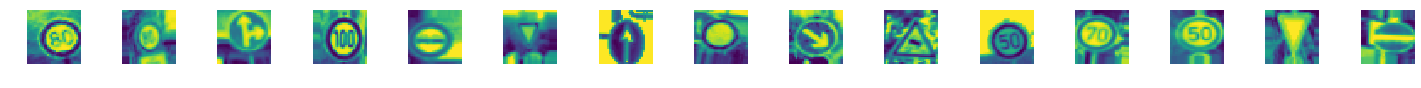

In [19]:
# Data Augmentation:


from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(x_train)
# for X_batch, y_batch in
 
batches = datagen.flow(x_train, y_train, batch_size = 15)
x_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(x_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(x_batch.shape)


In [20]:
print(x_batch.shape)
print(x_train.shape)
print(x_val.shape)

(15, 32, 32, 1)
(34799, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
# Convolutional Neural Network Architecture:


def cnn_model():
  
  model = Sequential()
  model.add(Conv2D(50, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(50, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(4, 4)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [22]:
# Confirming your model:

model = cnn_model()
print(model.summary())

W0723 03:35:10.978819 140067480160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 03:35:11.025884 140067480160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 03:35:11.035084 140067480160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 03:35:11.102158 140067480160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0723 03:35:11.163108 140067480160128 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 50)        1300      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 50)        62550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 50)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 30)          13530     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30)                0         
__________

In [29]:

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                             steps_per_epoch=1000,
                             epochs=11,
                             validation_data=(x_val, y_val), shuffle = 1)

Epoch 1/11
1000/1000 [==============================] - 274s 274ms/step - loss: 0.1641 - acc: 0.9483 - val_loss: 0.0799 - val_acc: 0.9755
Epoch 2/11
1000/1000 [==============================] - 274s 274ms/step - loss: 0.1462 - acc: 0.9547 - val_loss: 0.0903 - val_acc: 0.9717
Epoch 3/11
1000/1000 [==============================] - 275s 275ms/step - loss: 0.1473 - acc: 0.9538 - val_loss: 0.0839 - val_acc: 0.9796
Epoch 4/11
1000/1000 [==============================] - 274s 274ms/step - loss: 0.1310 - acc: 0.9596 - val_loss: 0.1053 - val_acc: 0.9667
Epoch 5/11
1000/1000 [==============================] - 277s 277ms/step - loss: 0.1357 - acc: 0.9577 - val_loss: 0.0618 - val_acc: 0.9812
Epoch 6/11
1000/1000 [==============================] - 275s 275ms/step - loss: 0.1302 - acc: 0.9597 - val_loss: 0.1044 - val_acc: 0.9653
Epoch 7/11
1000/1000 [==============================] - 276s 276ms/step - loss: 0.1232 - acc: 0.9628 - val_loss: 0.1050 - val_acc: 0.9714
Epoch 8/11
1000/1000 [============

Text(0.5, 0, 'epoch')

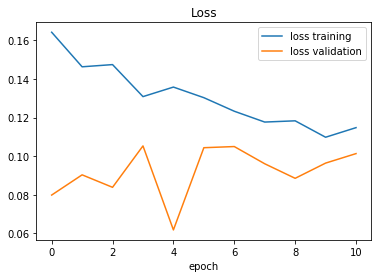

In [30]:
# Plotting loss and accuracy to study model for tuning:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss training','loss validation'])
plt.title('Loss')
plt.xlabel('epoch')
 


Testing Accuracy:95.54235946631866%


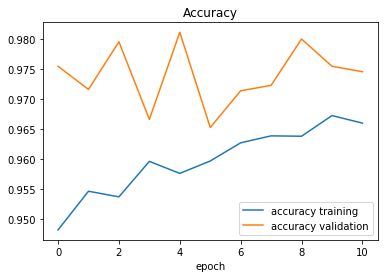

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy training','accuracy validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
 
score = model.evaluate(x_test, y_test, verbose=0)
print('Testing Accuracy:' + str(score[1] * 100.0) + "%")

(32, 32)
34    Predicted sign: Turn left aheadIndex:[34]
Name: SignName, dtype: object


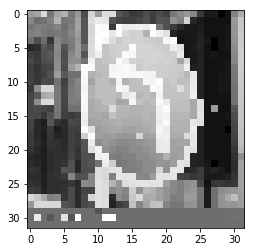

In [33]:
# Testing with images from the web to try the AI's prediction:

import requests
from PIL import Image
#url = "https://www.boyletoday.com/_wp_/wp-content/uploads/2018/07/IMG_0498-407x350.jpg"
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
#url = 'https://store.vitalsd.co.uk/media/catalog/product/cache/1/image/9df78eab33525d08d6e5fb8d27136e95/4/C/4C300909A321CBEEE9C67FCA5436BC56.jpg'
#url ="https://image.shutterstock.com/image-vector/turn-right-ahead-traffic-sign-260nw-1394106635.jpg"
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

class_index =  data['SignName']

class_prediction = model.predict_classes(img)
print("Predicted sign: "+ class_index[class_prediction] + "Index:" + str(class_prediction))